In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
from pathlib import Path
sys.path.insert(0, str(Path().resolve().parents[1]))
from model import left_right_task as lrt, network_model, plot_style, util

In [2]:
areas = np.load('trace_vs_det/areas.npy', allow_pickle=True)
WEE_mesh = np.load('trace_vs_det/WEE_mesh.npy', allow_pickle=True)
WEI_mesh = np.load('trace_vs_det/WEI_mesh.npy', allow_pickle=True)
WIE_mesh = np.load('trace_vs_det/WIE_mesh.npy', allow_pickle=True)
WII_mesh = np.load('trace_vs_det/WII_mesh.npy', allow_pickle=True)

In [3]:
n = 30
traces = np.logspace(0, 5, n) * -1
determinants = np.logspace(5, 7, n)
trace_mesh, determinant_mesh = np.meshgrid(traces, determinants)

WEE_mesh = WEE_mesh.reshape((n, n))
WEI_mesh = WEI_mesh.reshape((n, n))
WIE_mesh = WIE_mesh.reshape((n, n))
WII_mesh = WII_mesh.reshape((n, n))

In [4]:
m = 50
stimulus_durations = np.logspace(-3, 0, m)
stimulus_amplitudes = np.logspace(0, 2, m)
STIM_DUR, STIM_AMP = np.meshgrid(stimulus_durations, stimulus_amplitudes)
STIM_DUR_, STIM_AMP_ = STIM_DUR.ravel(), STIM_AMP.ravel()

In [5]:
n_stimuli = m ** 2
norm_areas = areas / n_stimuli
Lx = np.max(stimulus_durations)/np.min(stimulus_durations)
Ly = np.max(stimulus_amplitudes)/np.min(stimulus_amplitudes)
fold_areas = norm_areas.reshape((n, n)) * (Lx * Ly) # Area in fold-fold change space
radii = np.sqrt(fold_areas / np.pi) # radius expresses the fold change in terms of a circle's radius

In [8]:
selected_points = [(1, 3), (6, 8),(5, 20)]

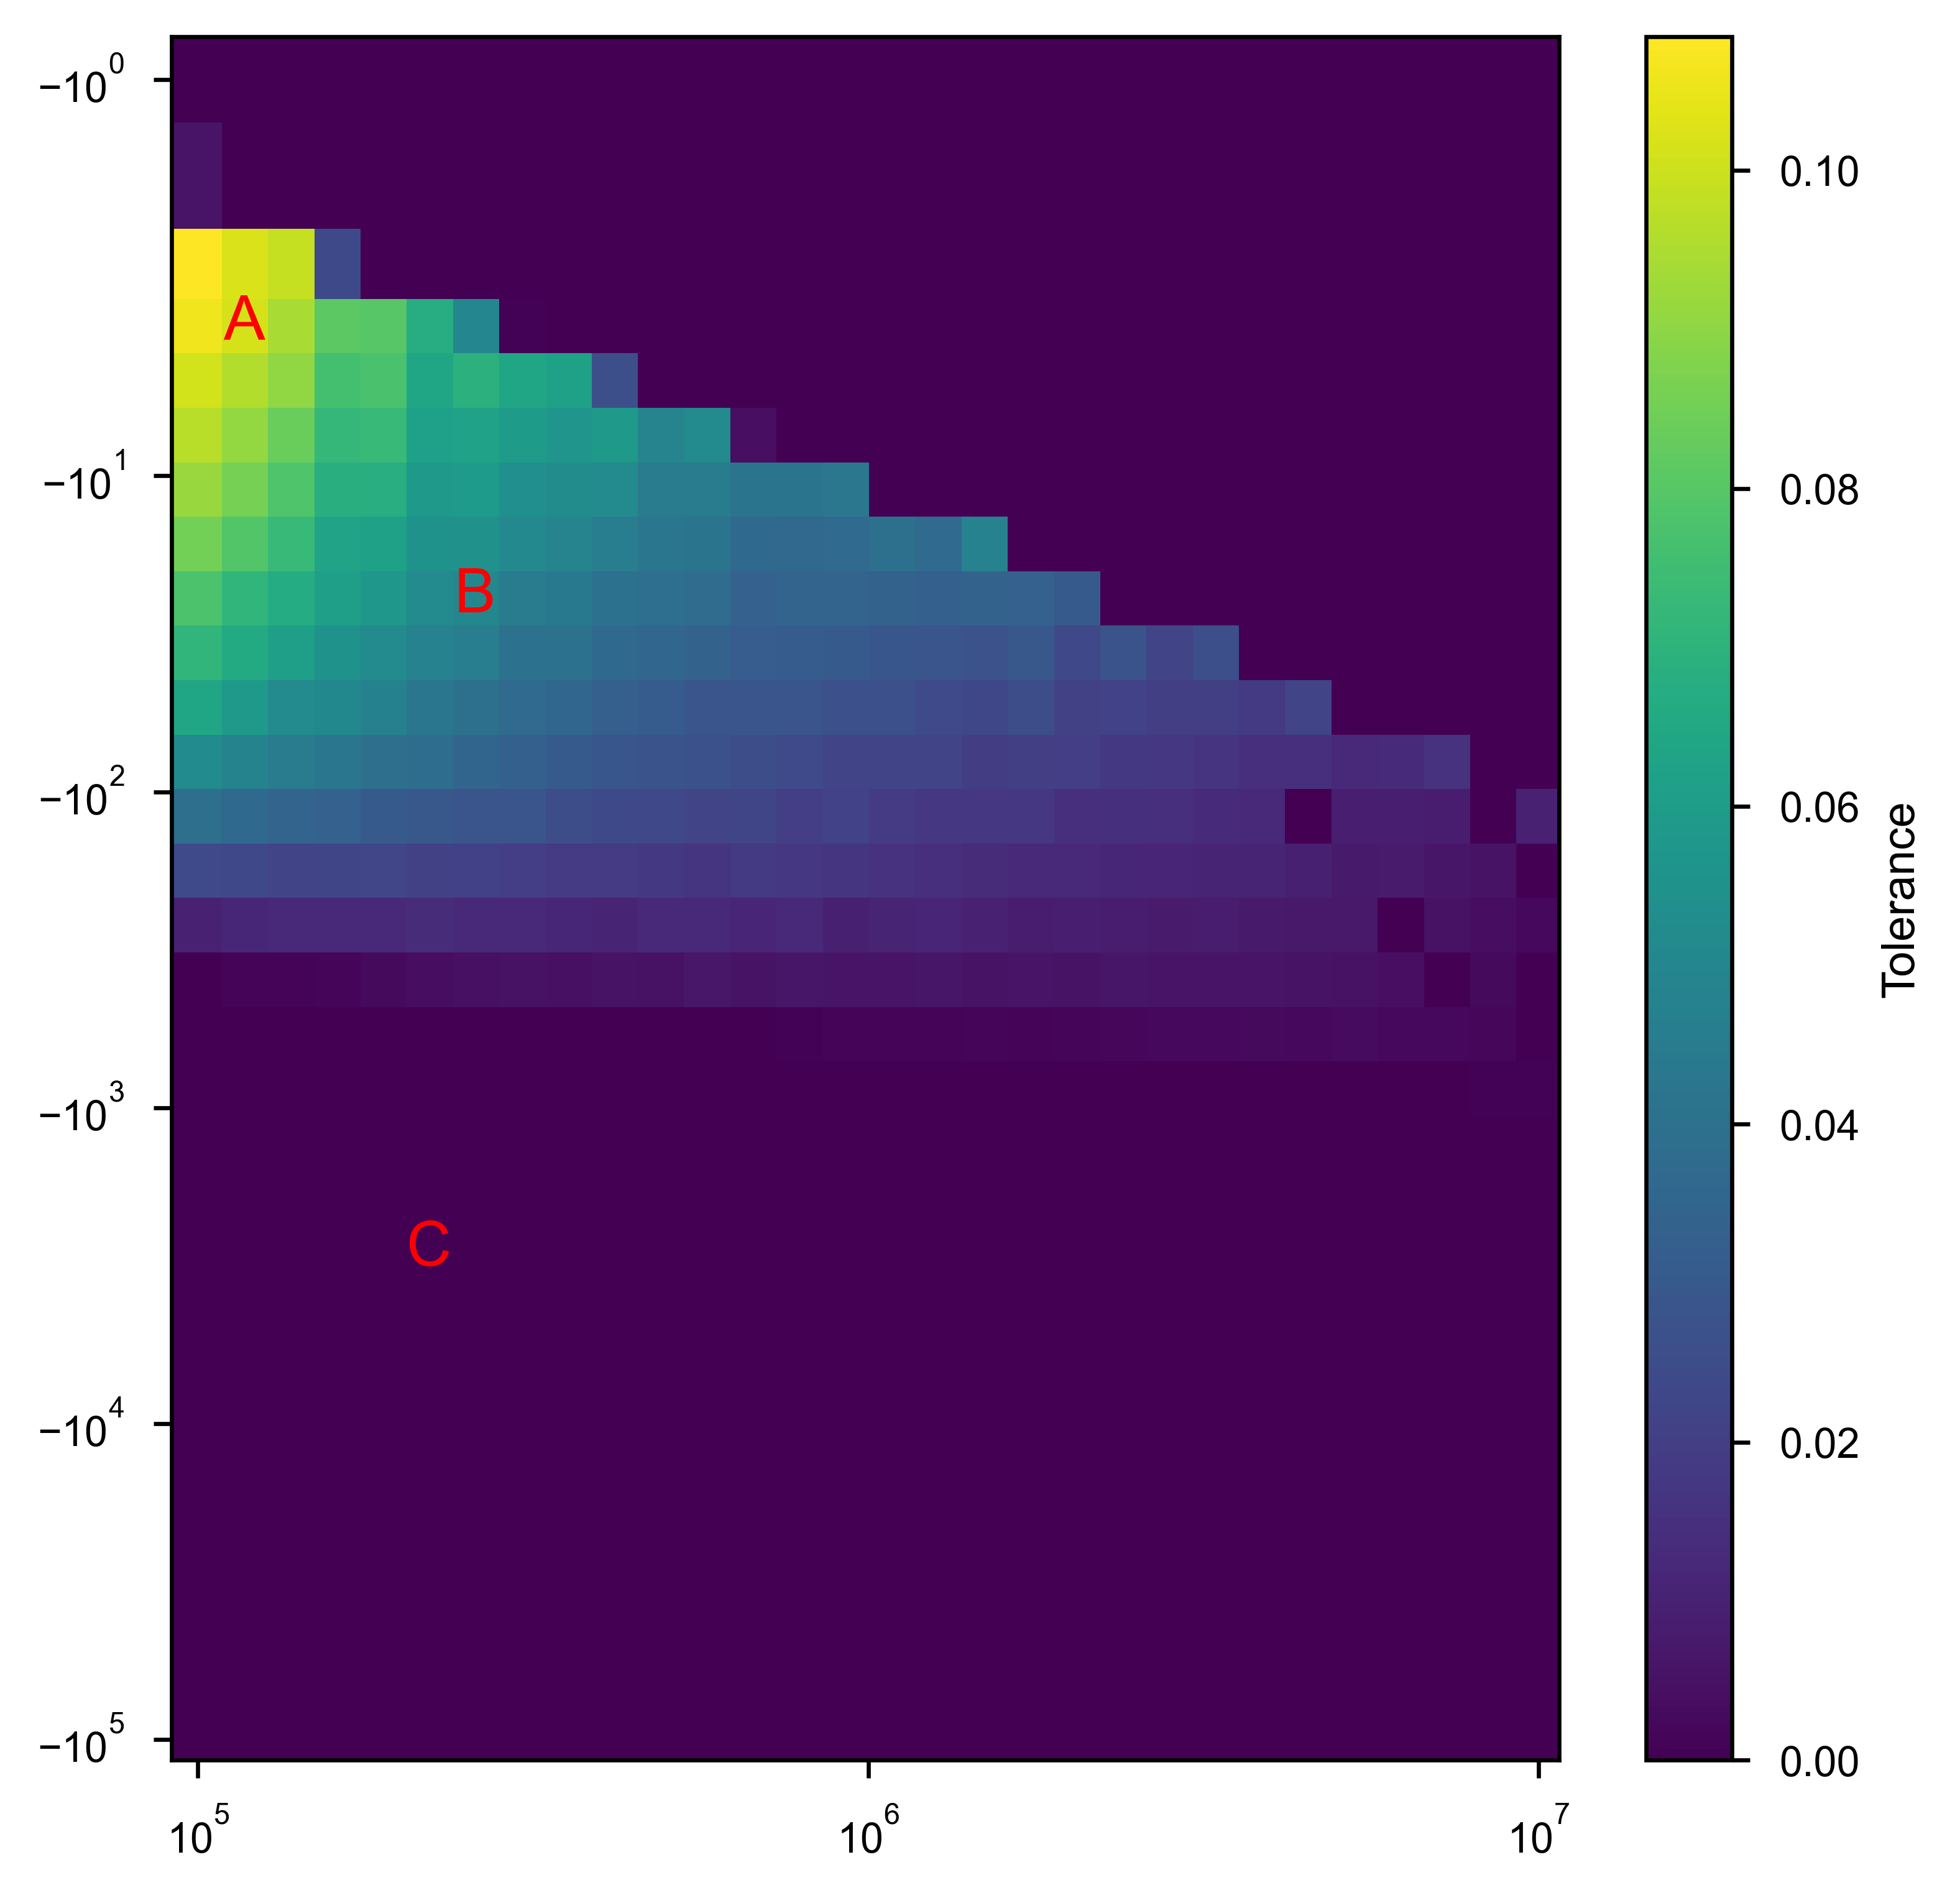

In [9]:
fig, ax = plt.subplots(figsize=(6,6))
c = ax.pcolormesh(determinant_mesh, trace_mesh, norm_areas.reshape(trace_mesh.shape), shading='auto', cmap='viridis')
for i, point in enumerate(selected_points):
    x, y = point
    ax.text(determinants[x], traces[y], chr(65 + i), color='red', fontsize=12, ha='center', va='center')
ax.set_xscale('symlog')
ax.set_yscale('symlog')
fig.colorbar(c, ax=ax, label='Tolerance')
plt.show()

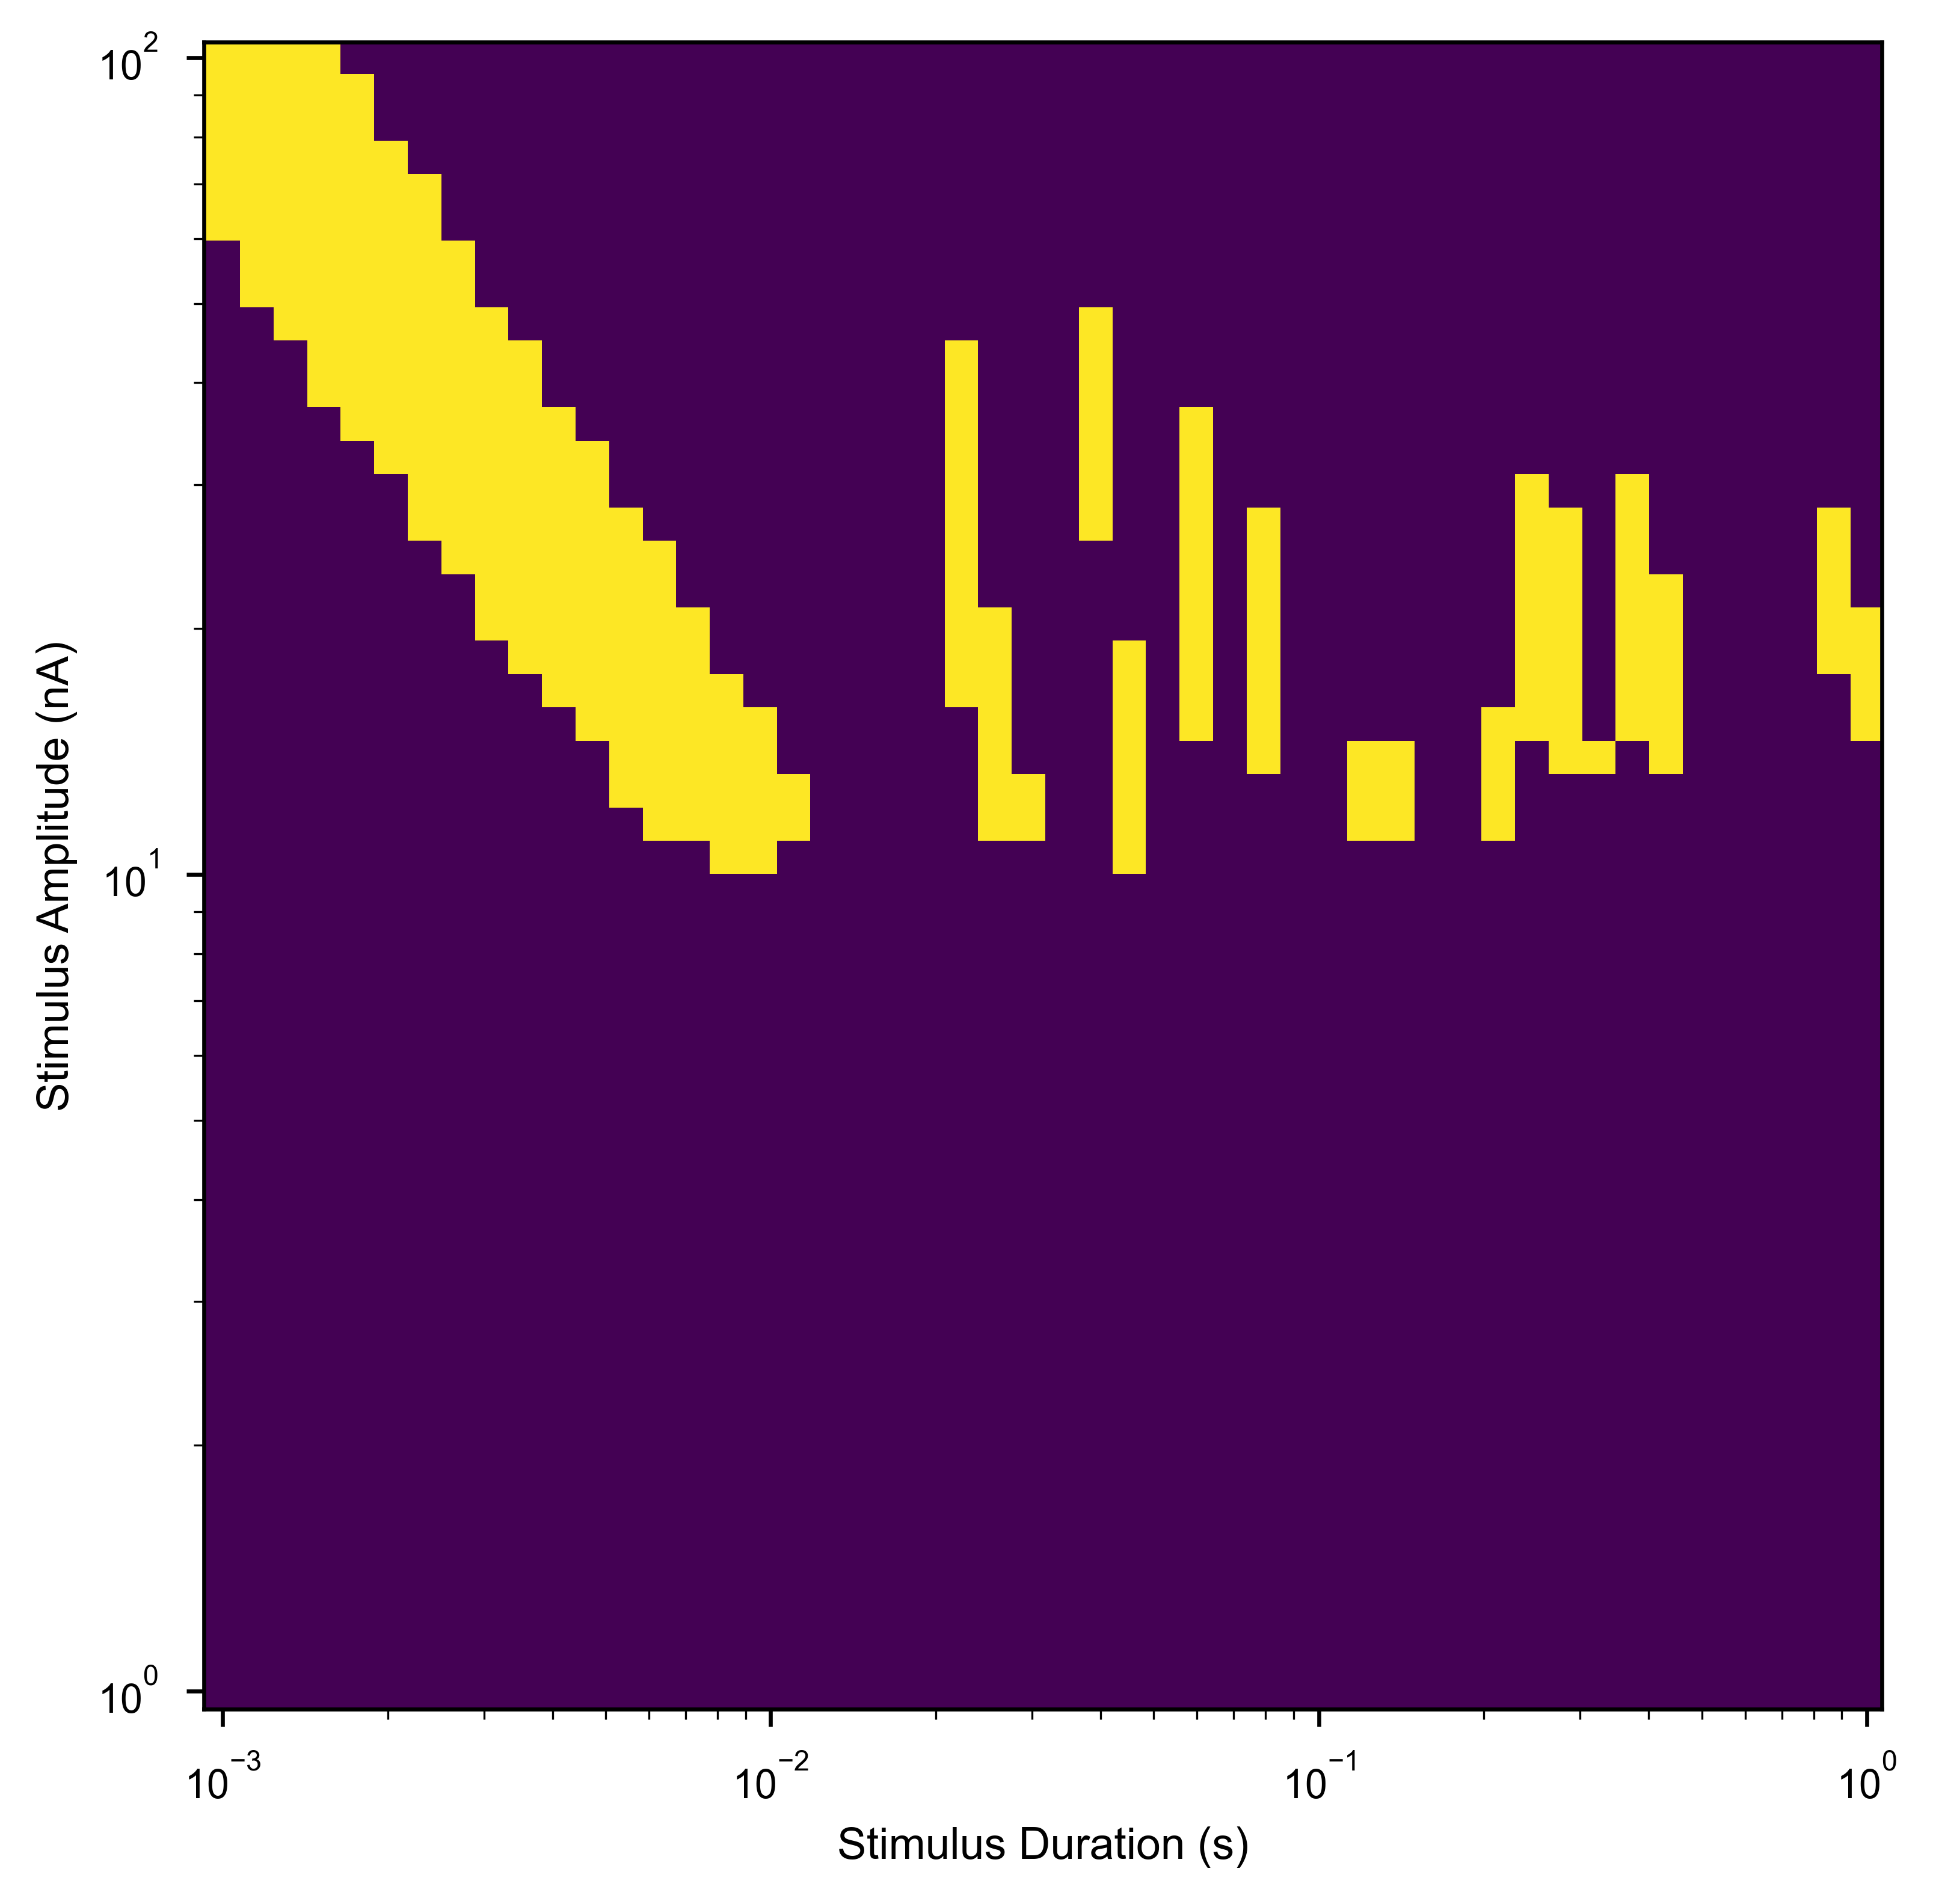

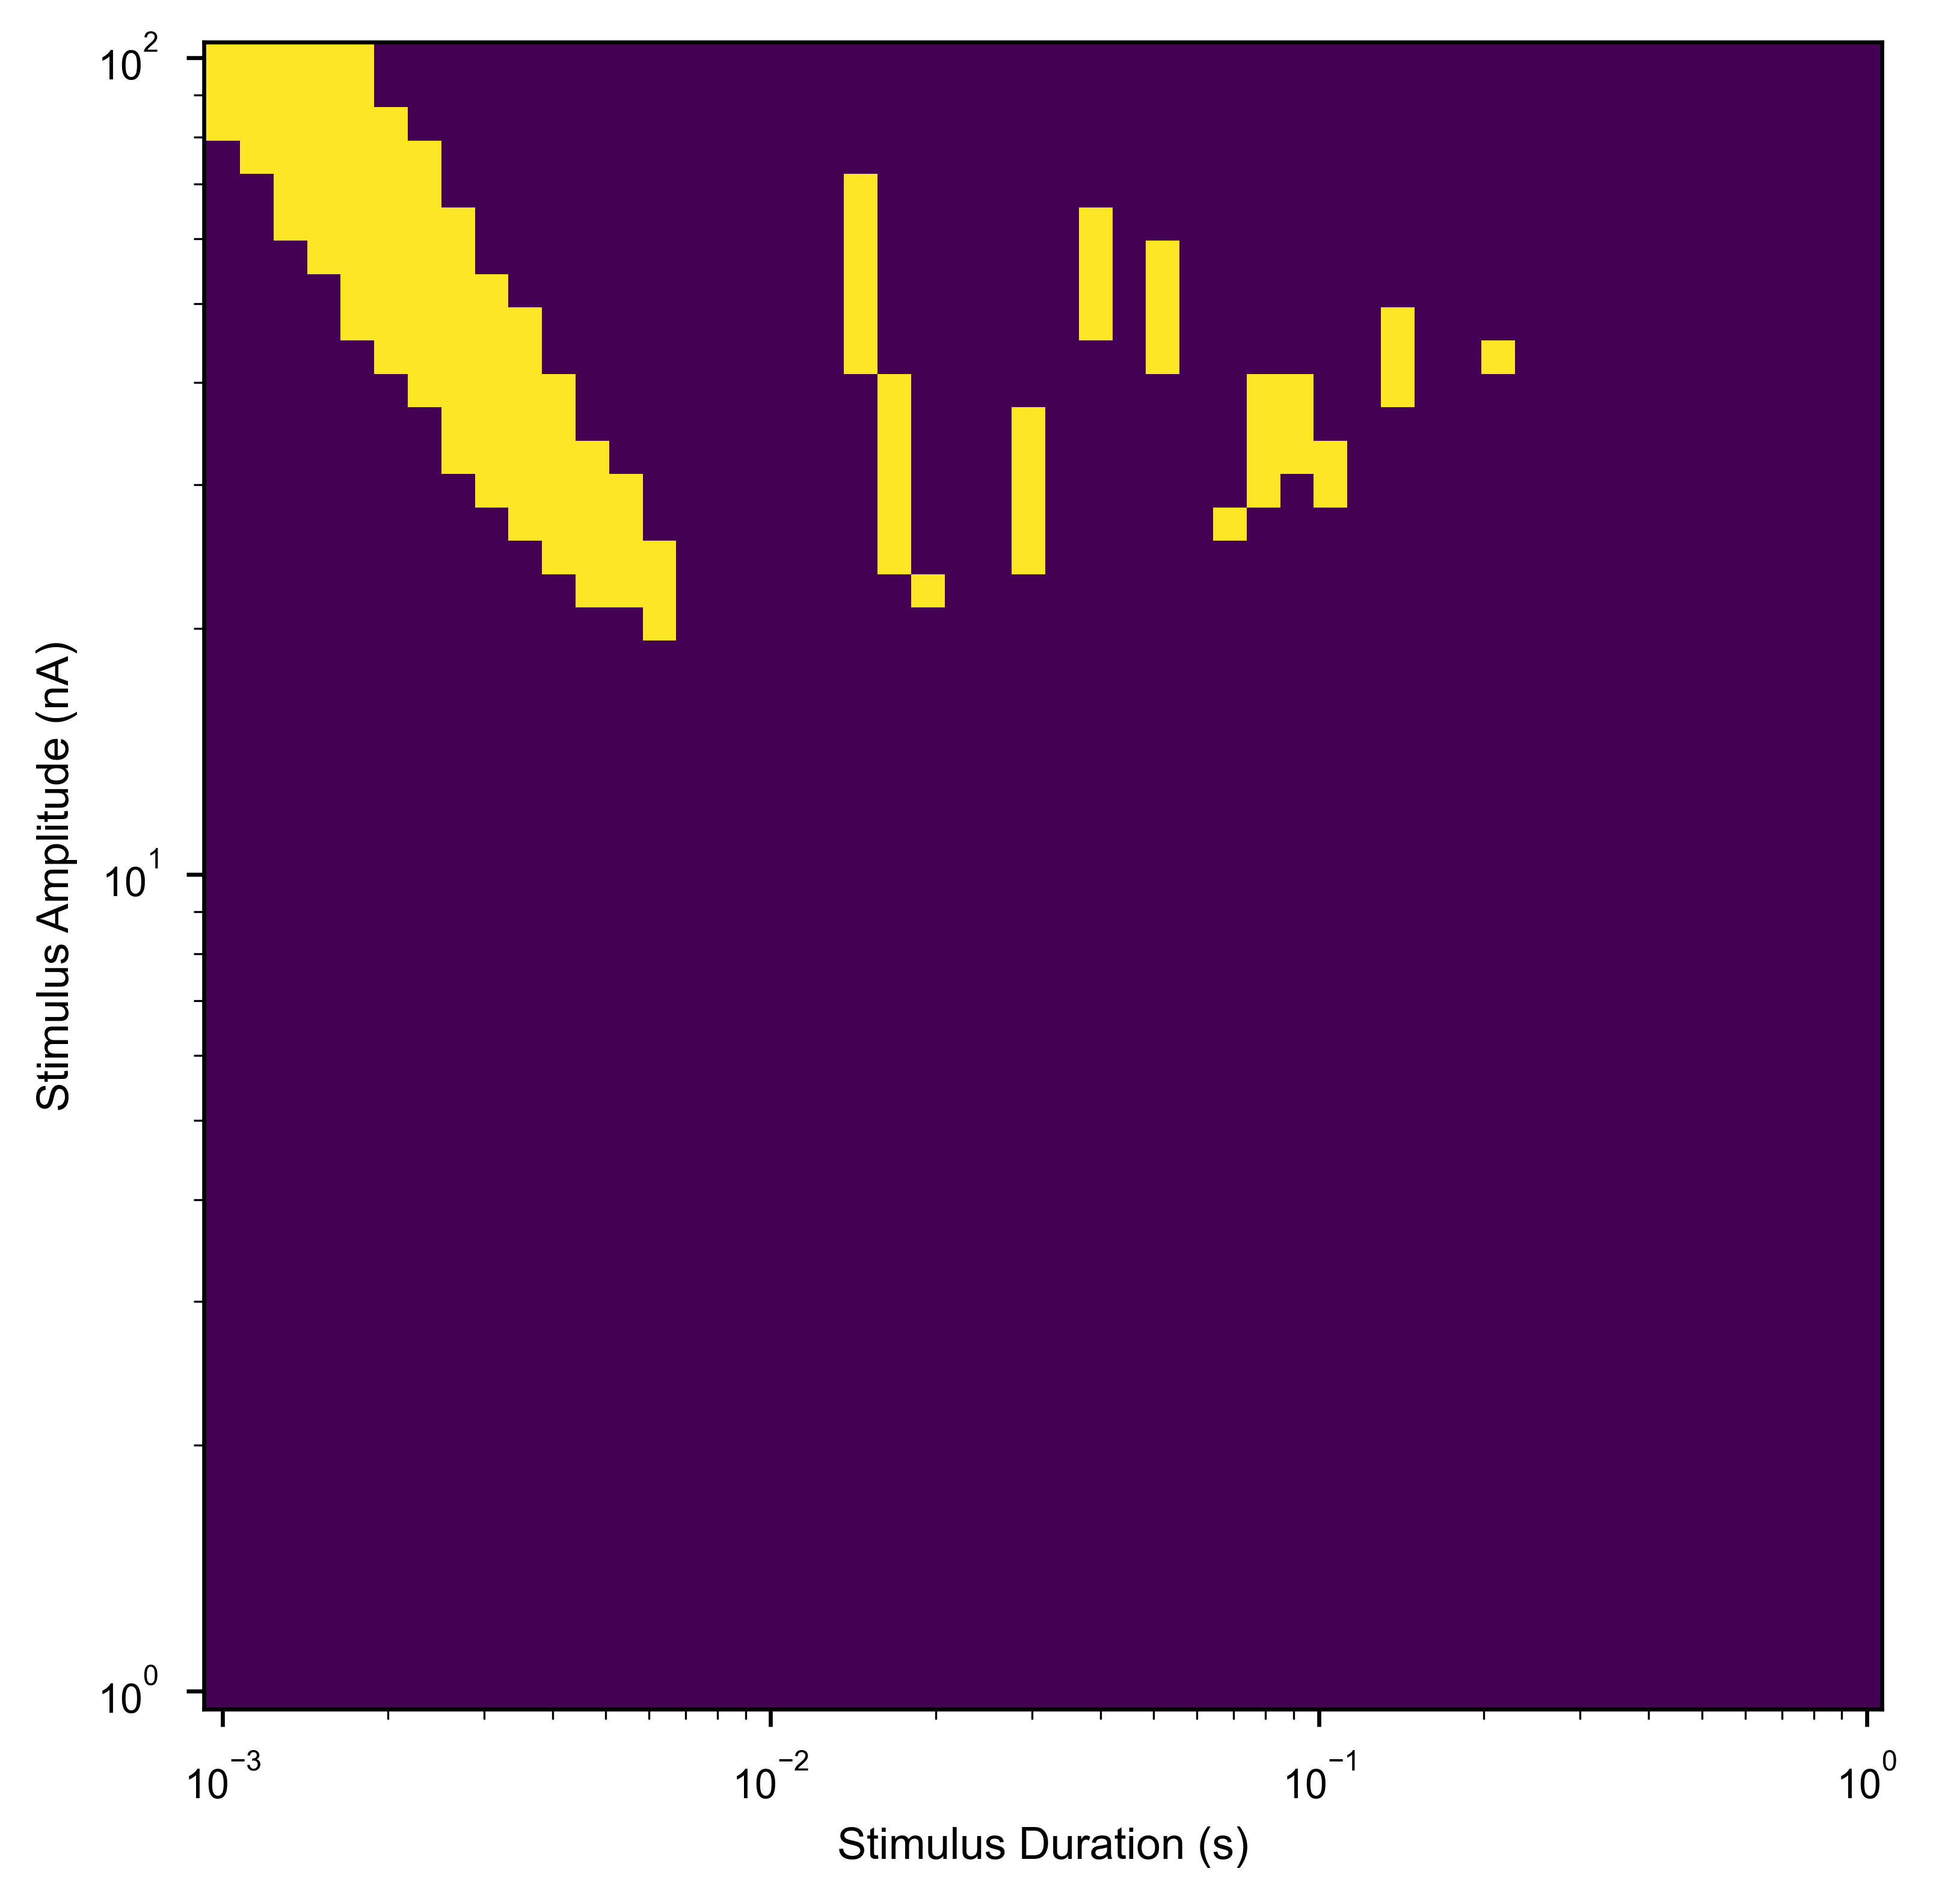

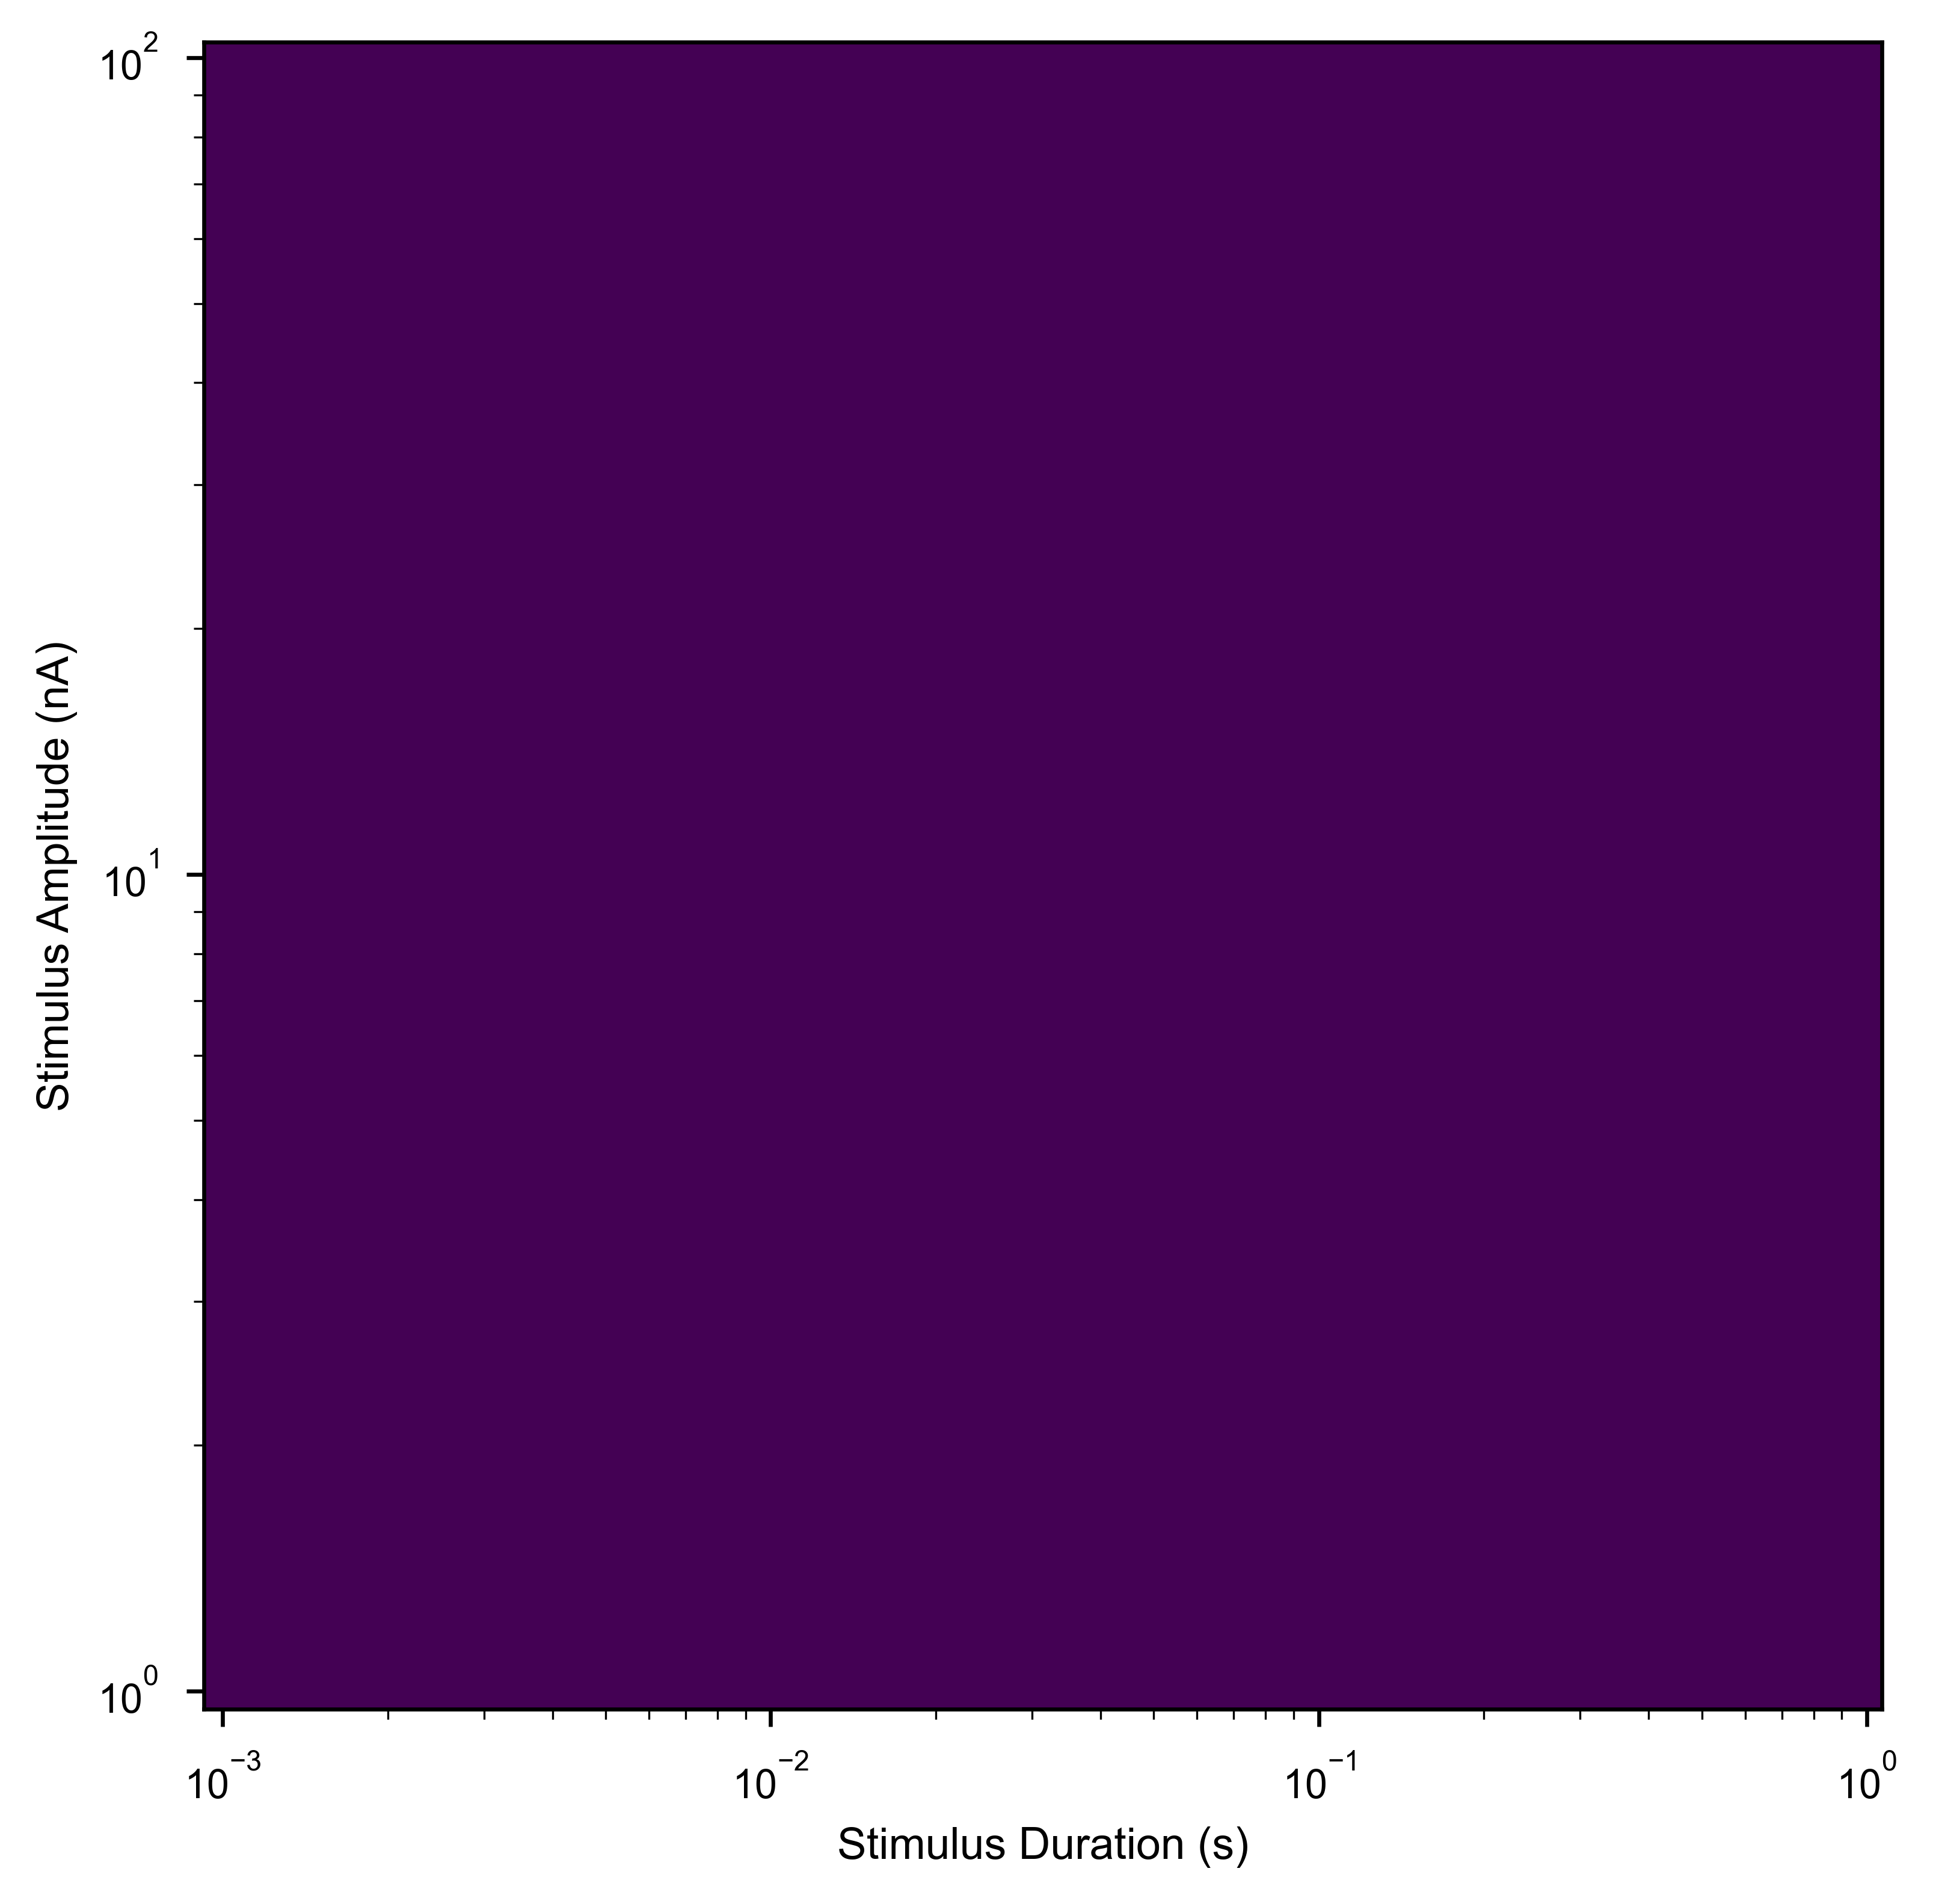

In [13]:
for x, y in selected_points:
    sweep_results = np.load(f'trace_vs_det/sample_({x},{y})_stim_sweep.npy', allow_pickle=True)
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.pcolormesh(STIM_DUR, STIM_AMP, sweep_results.reshape((m, m)), shading='auto', cmap='viridis')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Stimulus Duration (s)')
    ax.set_ylabel('Stimulus Amplitude (nA)')

# Final Figure

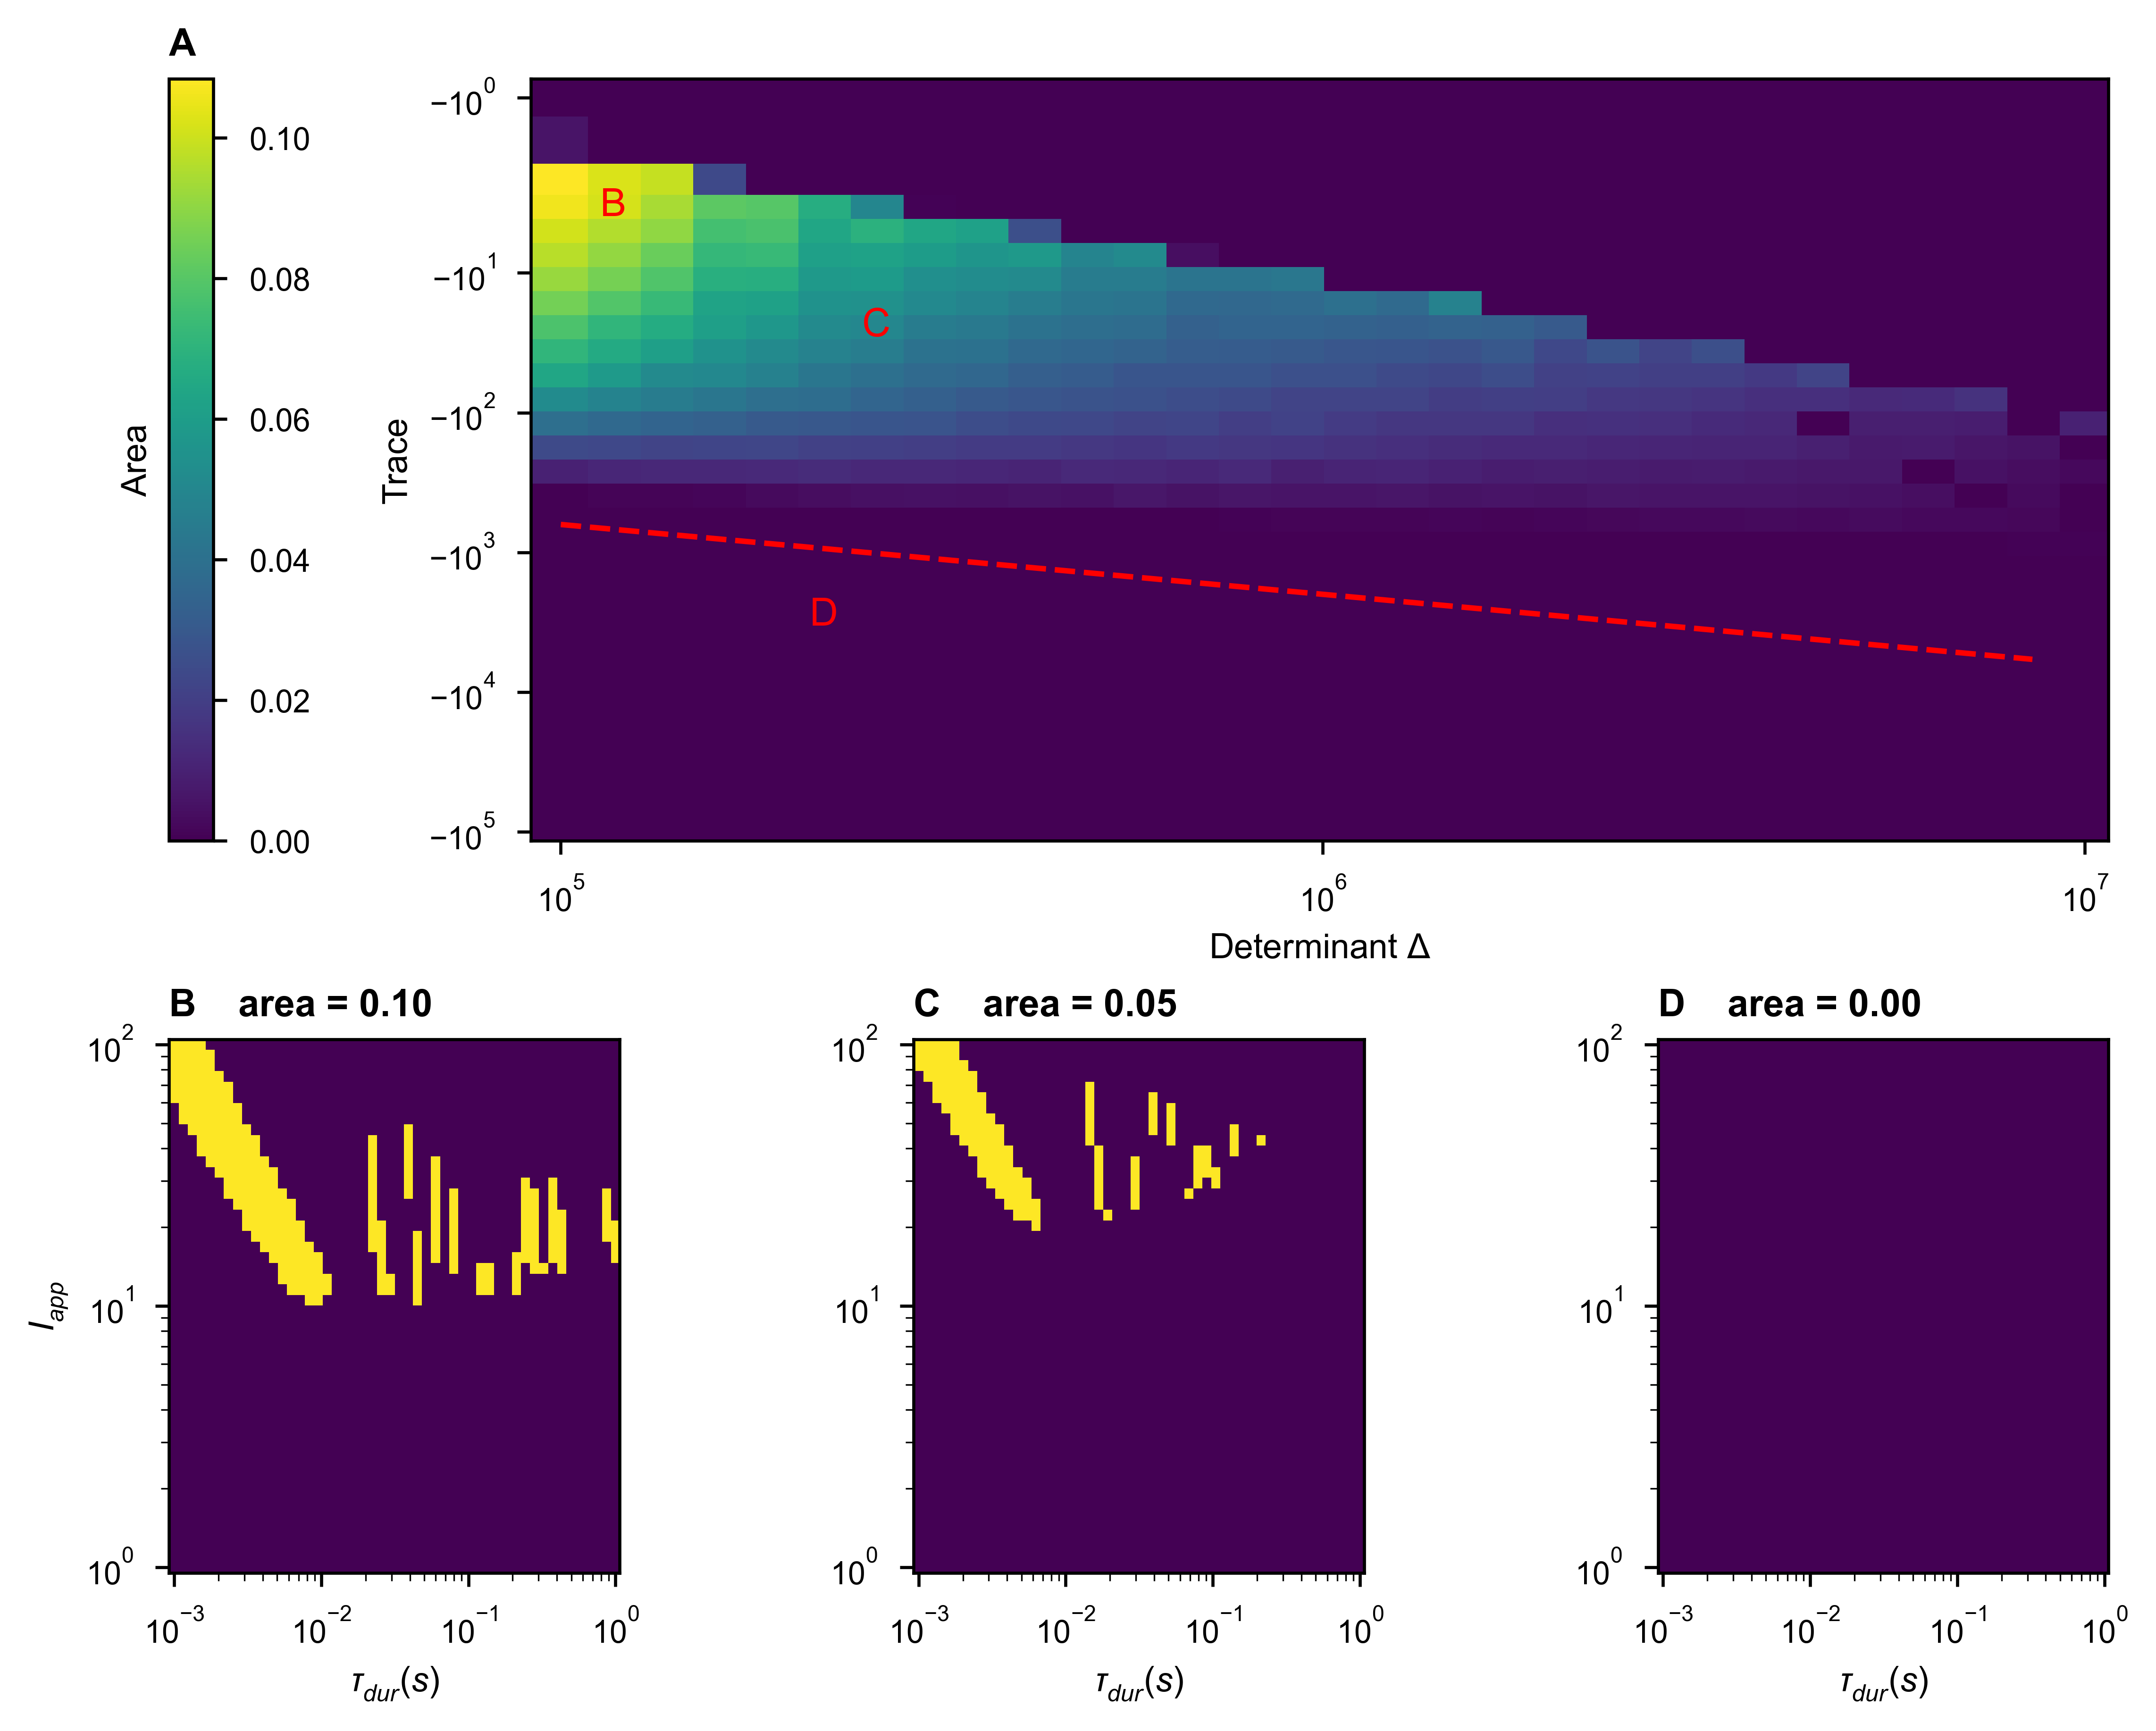

In [38]:
MIN_WIDTH = 1578    # in pixels at 600 dpi
MAX_WIDTH = 4500
MAX_HEIGHT = 5250

px = 1/plt.rcParams['figure.dpi']   # convert pixel to inches
fig = plt.figure(layout='constrained', figsize=(MAX_WIDTH*px, MAX_WIDTH*0.8*px))
axd = fig.subplot_mosaic(
    """
    Aaaaaa
    BBCCDD
    """,
    width_ratios=[0.5, 1, 0.5, 1, 0.5, 1],
    height_ratios = [1, 0.7]
)
# B, C, and D share the same y-axis
axd['B'].sharey(axd['C'])
axd['A'].set_title('A', loc='left', fontweight='bold')
for label, ax in axd.items():
    if label == 'd':
        continue
    if label == 'a':
        # plot the determinant vs trace mesh
        c = ax.pcolormesh(determinant_mesh, trace_mesh, norm_areas.reshape(trace_mesh.shape), shading='auto', cmap='viridis')
        for i, point in enumerate(selected_points):
            x, y = point
            ax.text(determinants[x], traces[y], chr(66 + i), color='red', fontsize=10, ha='center', va='center')
        ax.set_xscale('symlog')
        ax.set_yscale('symlog')
        ax.set(ylabel=r'Trace', xlabel=r'Determinant $\Delta$')
        # add line where tr**2 = 4*det
        det_line = determinants[:]
        trace_line = -2*np.sqrt(det_line)
        idx_max = np.argmax(trace_line < np.min(traces)) if np.min(trace_line) < np.min(traces) else -1
        idx_min = np.argmax(trace_line > np.max(traces)) if np.max(trace_line) > np.max(traces) else 0
        det_line = det_line[idx_min:idx_max]
        trace_line = trace_line[idx_min:idx_max]
        ax.plot(det_line, trace_line, 'r--', label=r'$tr^2 = 4 \cdot det$')
        cbar = fig.colorbar(c, cax=axd['A'])
        cbar.set_label('Area')
        cbar.ax.yaxis.set_label_position('left')
    elif label in ['B', 'C', 'D']:        
        sweep_results = np.load(f'trace_vs_det/sample_({selected_points[ord(label) - ord("B")][0]},{selected_points[ord(label) - ord("B")][1]})_stim_sweep.npy', allow_pickle=True)
        ax.set_title(label + f"    area = {(np.sum(sweep_results > 0) / n_stimuli):.2f}", loc='left', fontweight='bold')
        c = ax.pcolormesh(STIM_DUR, STIM_AMP, sweep_results.reshape((m, m)), shading='auto', cmap='viridis')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel(r'$\tau_{dur} (s)$')
        if label == 'B':
            ax.set_ylabel(r'$I_{app}$')
plt.show()